In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import count
import numpy as np
from pyspark.sql.window import Window
import os

In [2]:
# Vérifiez si un SparkContext existe déjà
if 'sc' in locals() or 'sc' in globals():
    sc.stop()  # Arrêtez le SparkContext précédent
    
spark = SparkSession.builder \
    .appName("ExploreRatingCSV") \
    .master("yarn") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/02 08:47:24 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
# Read the CSV file
ratings_df = spark.read.csv("hdfs:///input/rating.csv", header=True, inferSchema=True)
movies_df = spark.read.csv("hdfs:///input/movie.csv", header=True, inferSchema=True)

# Rating

In [4]:
# Afficher les 5 premières lignes de ratings_df
print("Premières lignes de ratings_df:")
ratings_df.show(5)

Premières lignes de ratings_df:
+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
+------+-------+------+-------------------+
only showing top 5 rows



In [5]:
# Vérification des valeurs nulles dans ratings_df
print("Vérification des valeurs nulles dans ratings_df :")
ratings_null_counts = ratings_df.select([((F.col(c).isNull()).cast("int")).alias(c) for c in ratings_df.columns]) \
                                .agg(*[F.sum(F.col(c)).alias(c) for c in ratings_df.columns]) \
                                .collect()[0].asDict()
for col_name, null_count in ratings_null_counts.items():
    print(f"{col_name}: {null_count} null(s)")

# Afficher les lignes contenant des valeurs nulles dans ratings_df
print("\nLignes contenant des valeurs nulles dans ratings_df :")
condition = None
for c in ratings_df.columns:
    if condition is None:
        condition = F.col(c).isNull()
    else:
        condition = condition | F.col(c).isNull()

ratings_df.filter(condition).show(5)

# Vérification des doublons dans ratings_df
print("\nVérification des doublons dans ratings_df :")
duplicates_count = ratings_df.count() - ratings_df.distinct().count()
print(f"Nombre de doublons : {duplicates_count}")
ratings_df.groupBy(ratings_df.columns).count().filter("count > 1").show(5)

Vérification des valeurs nulles dans ratings_df :


userId: 0 null(s)
movieId: 0 null(s)
rating: 0 null(s)
timestamp: 0 null(s)

Lignes contenant des valeurs nulles dans ratings_df :


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
+------+-------+------+---------+


Vérification des doublons dans ratings_df :


Nombre de doublons : 0


[Stage 26:>                                                         (0 + 1) / 1]

+------+-------+------+---------+-----+
|userId|movieId|rating|timestamp|count|
+------+-------+------+---------+-----+
+------+-------+------+---------+-----+



In [6]:
# Compter le nombre d'évaluations par utilisateur
user_rating_counts = ratings_df.groupBy("userId").count()

# Filtrer pour obtenir les utilisateurs ayant moins de deux évaluations
users_with_less_than_two = user_rating_counts.filter(F.col("count") < 2)

# Compter le nombre total d'utilisateurs concernés
num_users_with_less_than_two = users_with_less_than_two.count()

print(f"Nombre d'utilisateurs ayant moins de deux évaluations: {num_users_with_less_than_two}")

# Afficher quelques exemples de ces utilisateurs et leur nombre d'évaluations
print("\nExemples d'utilisateurs avec moins de deux évaluations:")
users_with_less_than_two.show(5)

Nombre d'utilisateurs ayant moins de deux évaluations: 0

Exemples d'utilisateurs avec moins de deux évaluations:


[Stage 33:================================================>         (5 + 1) / 6]

+------+-----+
|userId|count|
+------+-----+
+------+-----+



In [7]:
# Compter le nombre de films distincts évalués par chaque utilisateur
distinct_movie_counts = ratings_df.groupBy("userId").agg(
    F.countDistinct("movieId").alias("distinct_movies_rated")
)

# Trier par nombre de films distincts en ordre croissant
sorted_users = distinct_movie_counts.orderBy("distinct_movies_rated")

# Trouver l'utilisateur avec le moins de films distincts évalués
user_with_least_movies = sorted_users.first()

print(f"L'utilisateur ayant évalué le moins de films distincts est:")
print(f"userId: {user_with_least_movies['userId']}, avec {user_with_least_movies['distinct_movies_rated']} film(s) évalué(s)")

# Afficher les 5 utilisateurs ayant évalué le moins de films distincts
print("\nLes 5 utilisateurs ayant évalué le moins de films distincts:")
sorted_users.show(5)

# Pour examiner les évaluations de cet utilisateur 
user_id = user_with_least_movies['userId']
print(f"\nDétail des évaluations de l'utilisateur {user_id}:")
ratings_df.filter(F.col("userId") == user_id).show()

L'utilisateur ayant évalué le moins de films distincts est:
userId: 8662, avec 20 film(s) évalué(s)

Les 5 utilisateurs ayant évalué le moins de films distincts:


+------+---------------------+
|userId|distinct_movies_rated|
+------+---------------------+
| 11317|                   20|
| 43833|                   20|
| 59990|                   20|
|100553|                   20|
| 38153|                   20|
+------+---------------------+
only showing top 5 rows


Détail des évaluations de l'utilisateur 8662:


+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|  8662|     48|   2.5|2006-11-16 02:01:14|
|  8662|     58|   1.5|2006-11-16 02:01:16|
|  8662|    236|   1.0|2006-11-16 02:01:05|
|  8662|    485|   2.0|2006-11-16 02:01:25|
|  8662|    805|   2.0|2006-11-16 02:01:30|
|  8662|    903|   2.5|2006-11-16 02:01:31|
|  8662|   1094|   1.5|2006-11-16 02:01:04|
|  8662|   1233|   1.0|2006-11-16 02:01:21|
|  8662|   1234|   3.5|2006-11-16 02:01:19|
|  8662|   1250|   1.0|2006-11-16 02:01:24|
|  8662|   1676|   1.0|2006-11-16 02:02:18|
|  8662|   1777|   4.0|2006-11-16 02:01:32|
|  8662|   1954|   2.5|2006-11-16 02:01:29|
|  8662|   2006|   2.0|2006-11-16 02:01:27|
|  8662|   2712|   3.0|2006-11-16 02:01:08|
|  8662|   3175|   2.0|2006-11-16 02:01:26|
|  8662|   3481|   0.5|2006-11-16 02:01:11|
|  8662|   4022|   2.5|2006-11-16 02:00:45|
|  8662|   5060|   1.0|2006-11-16 02:01:01|
|  8662|   6377|   1.0|2006-11-1

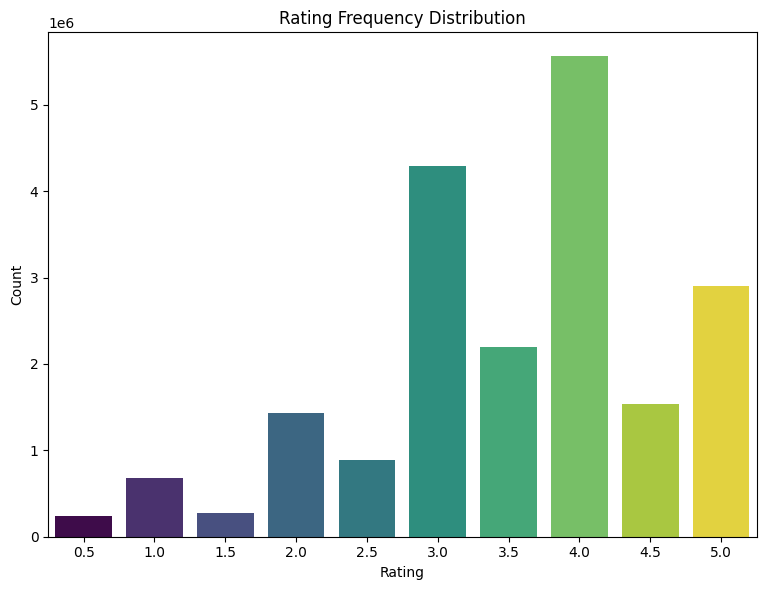

In [20]:
# Agréger d'abord côté Spark (faible volume, typiquement < 20 lignes)
agg_df = ratings_df.groupBy("rating").count().orderBy("rating")

# Convertir en pandas (ici c’est sûr que ça tient en mémoire)
agg_pd = agg_df.toPandas()

# Calculer la distribution cumulative
agg_pd["percentage"] = agg_pd["count"] / agg_pd["count"].sum()
agg_pd["cumulative"] = agg_pd["percentage"].cumsum()

plt.figure(figsize=(15, 6))

# 📊 Distribution simple
plt.subplot(1, 2, 1)
sns.barplot(x="rating", y="count", hue="rating", data=agg_pd, palette="viridis", legend=False)
plt.title('Rating Frequency Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Movie

In [8]:
# Afficher les 5 premières lignes de movies_df
print("Premières lignes de movies_df:")
movies_df.show(5)

Premières lignes de movies_df:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [9]:
# Vérification des valeurs nulles dans movies_df
print("\nVérification des valeurs nulles dans movies_df :")
movies_null_counts = movies_df.select([((F.col(c).isNull()).cast("int")).alias(c) for c in movies_df.columns]) \
                              .agg(*[F.sum(F.col(c)).alias(c) for c in movies_df.columns]) \
                              .collect()[0].asDict()
for col_name, null_count in movies_null_counts.items():
    print(f"{col_name}: {null_count} null(s)")

# Afficher les lignes contenant des valeurs nulles dans movies_df
print("\nLignes contenant des valeurs nulles dans movies_df :")
condition = None
for c in movies_df.columns:
    if condition is None:
        condition = F.col(c).isNull()
    else:
        condition = condition | F.col(c).isNull()

movies_df.filter(condition).show(5)

# Vérification des doublons dans movies_df
print("\nVérification des doublons dans movies_df :")
duplicates_count = movies_df.count() - movies_df.distinct().count()
print(f"Nombre de doublons : {duplicates_count}")
movies_df.groupBy(movies_df.columns).count().filter("count > 1").show(5)


Vérification des valeurs nulles dans movies_df :
movieId: 0 null(s)
title: 0 null(s)
genres: 0 null(s)

Lignes contenant des valeurs nulles dans movies_df :
+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
+-------+-----+------+


Vérification des doublons dans movies_df :
Nombre de doublons : 0
+-------+-----+------+-----+
|movieId|title|genres|count|
+-------+-----+------+-----+
+-------+-----+------+-----+



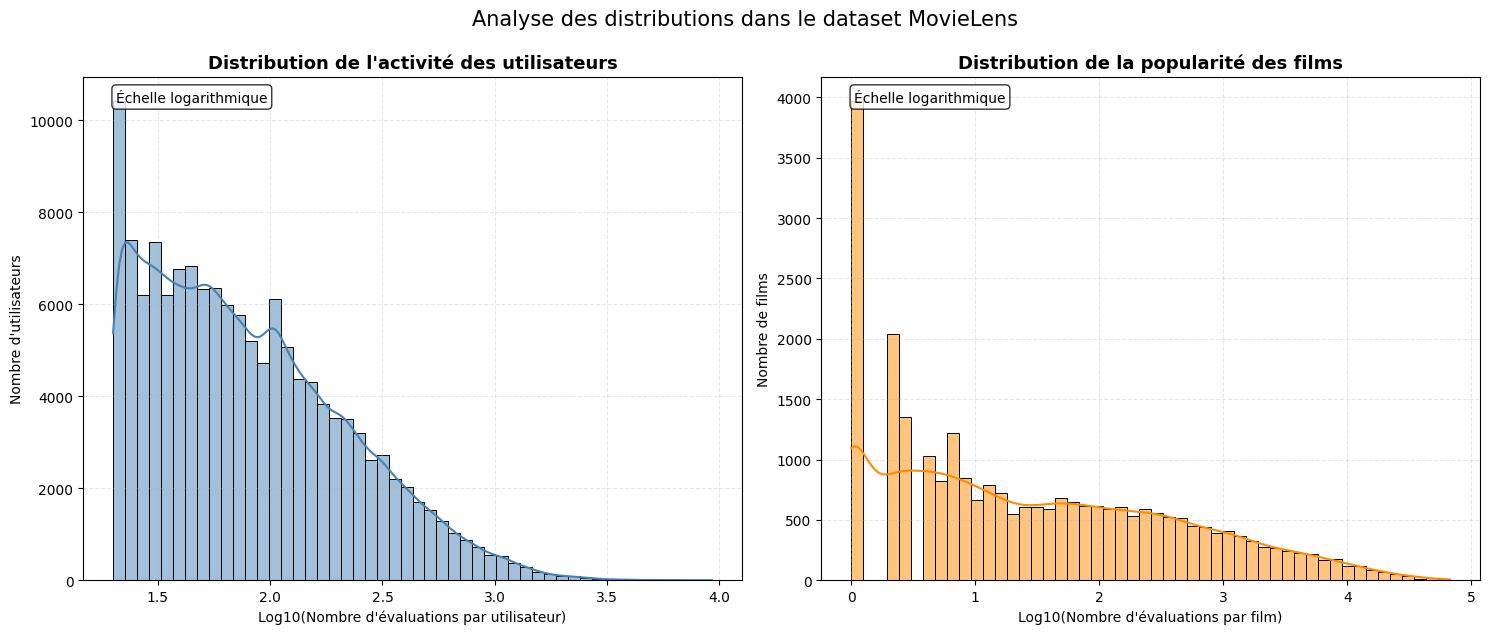

In [27]:
# Activité des utilisateurs : nombre de notes par user
user_activity_df = ratings_df.groupBy("userId").agg(count("*").alias("rating_count"))
user_activity_pd = user_activity_df.toPandas()

# Popularité des films : nombre de notes par film
movie_popularity_df = ratings_df.groupBy("movieId").agg(count("*").alias("rating_count"))
movie_popularity_pd = movie_popularity_df.toPandas()

plt.figure(figsize=(15, 6))

# 📊 Activité utilisateurs - avec labels améliorés et nouvelle couleur
plt.subplot(1, 2, 1)
sns.histplot(np.log10(user_activity_pd["rating_count"]), bins=50, kde=True, color='steelblue')
plt.title('Distribution de l\'activité des utilisateurs', fontsize=13, fontweight='bold')
plt.xlabel('Log10(Nombre d\'évaluations par utilisateur)')
plt.ylabel('Nombre d\'utilisateurs')
plt.grid(True, alpha=0.3, linestyle='--')
plt.annotate('Échelle logarithmique', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

# 📊 Popularité des films - avec labels améliorés et nouvelle couleur
plt.subplot(1, 2, 2)
sns.histplot(np.log10(movie_popularity_pd["rating_count"]), bins=50, kde=True, color='darkorange')
plt.title('Distribution de la popularité des films', fontsize=13, fontweight='bold')
plt.xlabel('Log10(Nombre d\'évaluations par film)')
plt.ylabel('Nombre de films')
plt.grid(True, alpha=0.3, linestyle='--')
plt.annotate('Échelle logarithmique', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.suptitle('Analyse des distributions dans le dataset MovieLens', fontsize=15, y=1.05)
plt.show()

Analyse des Distributions du Dataset MovieLens
1. Comportement des Utilisateurs
Le graphique de gauche révèle comment les utilisateurs interagissent avec la plateforme:

Distribution logarithmique: La visualisation utilise une échelle logarithmique (base 10) pour représenter efficacement la large gamme d'activités utilisateur
Zone d'activité typique: La majorité des utilisateurs évaluent entre 30 et 300 films (10^1.5 à 10^2.5)
Comportement médian: Le pic à 10^1.5 indique qu'un utilisateur typique évalue environ 30-40 films
"Super-utilisateurs": La queue de distribution montre une minorité d'utilisateurs très actifs évaluant jusqu'à 3000+ films (10^3.5)

2. Popularité des Films
Le graphique de droite montre comment l'attention se distribue parmi les films:

Forte inégalité: La courbe révèle une distribution extrêmement asymétrique avec un pic prononcé près de 10^0
"Longue traîne": La grande majorité des films reçoit très peu d'évaluations (entre 1 et 10)
Films blockbusters: Un petit nombre de films accumule des milliers d'évaluations (jusqu'à 10^4)
Loi de puissance: Cette distribution suit typiquement une loi de puissance, caractéristique des phénomènes de popularité

3. Implications pour les Systèmes de Recommandation
Ces distributions ont des conséquences importantes pour la conception d'algorithmes efficaces:
Défis Techniques

Matrice creuse: La matrice utilisateurs-films contient principalement des valeurs manquantes, compliquant l'analyse
Signal-bruit: Les films peu évalués offrent un signal statistique faible pour les prédictions
Déséquilibre d'information: Les décisions sont souvent biaisées vers les items populaires et les utilisateurs actifs

Stratégies de Correction

Normalisation des données: Pondérer les évaluations pour réduire l'influence disproportionnée des super-utilisateurs
Régularisation: Appliquer des techniques comme la régularisation L2 dans les modèles de factorisation matricielle
Diversification forcée: Intégrer des mécanismes pour promouvoir les contenus de la longue traîne
Approches hybrides: Combiner le filtrage collaboratif avec des méthodes basées sur le contenu moins sensibles aux biais

Opportunités

Segmentation d'utilisateurs: Identifier des groupes d'utilisateurs avec différents niveaux d'engagement
Découvrabilité: Créer des mécanismes pour aider les utilisateurs à découvrir des films de niche
Personnalisation avancée: Exploiter les données des super-utilisateurs comme source d'information riche pour améliorer les recommandations pour tous

Ces distributions asymétriques sont caractéristiques des systèmes de recommandation et représentent à la fois un défi et une opportunité pour développer des algorithmes plus sophistiqués et équitables.

# Ponderation

In [ ]:
# Chemin de sortie
output_path = "hdfs:///processed/weighted_ratings.csv"

print("🧮 Calcul des statistiques pour la pondération...")
# 1. Statistiques utilisateur
user_stats = ratings_df.groupBy("userId").agg(
    F.count("rating").alias("user_count"),
    F.avg("rating").alias("user_mean"), 
    F.stddev("rating").alias("user_stddev")
)

# 2. Statistiques film
movie_stats = ratings_df.groupBy("movieId").agg(
    F.count("rating").alias("movie_count"),
    F.avg("rating").alias("movie_avg_rating")
)

print("⚖️ Application des pondérations...")
# Joindre les statistiques aux données
weighted_df = ratings_df.join(user_stats, on="userId") \
                        .join(movie_stats, on="movieId") \
                        .join(movies_df, on="movieId")  # Ajouter les informations du film

# Calculer les évaluations normalisées et les poids
processed_df = weighted_df.withColumn(
    # Normalisation Z-score par utilisateur
    "normalized_rating", 
    (F.col("rating") - F.col("user_mean")) / 
    F.when(F.col("user_stddev") > 0, F.col("user_stddev")).otherwise(1.0)
).withColumn(
    # Poids utilisateur (inversement proportionnel à l'activité)
    "user_weight", 
    1.0 / F.log1p(F.col("user_count"))
).withColumn(
    # Poids film (inversement proportionnel à la popularité)
    "movie_weight", 
    1.0 / F.log1p(F.col("movie_count"))
).withColumn(
    # Confiance combinée
    "confidence", 
    F.col("user_weight") * F.col("movie_weight")
)

# Sélectionner et renommer les colonnes pour clarté
final_df = processed_df.select(
    "userId", 
    "movieId",
    "rating",
    "normalized_rating",
    "confidence",
    "user_mean",
    "user_stddev",
    "movie_count",
    "title",      # du fichier movies.csv
    "genres",     # du fichier movies.csv
    "timestamp"   # garder le timestamp pour pouvoir faire des splits temporels
)

print(f"💾 Enregistrement du fichier CSV pondéré dans {output_path}...")
# Vérifier si le répertoire existe et le supprimer s'il existe déjà
try:
    spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()).delete(
        spark._jvm.org.apache.hadoop.fs.Path(output_path), True)
except:
    pass  # Le chemin n'existe pas, on continue

# Enregistrer en CSV
final_df.write.csv(output_path, header=True, mode="overwrite")

print("✅ Prétraitement terminé! Fichier pondéré prêt à être utilisé.")

# Afficher un aperçu des données
print("\n📊 Aperçu des données pondérées:")
final_df.select("userId", "movieId", "title", "rating", "normalized_rating", "confidence").show(5)

# Afficher quelques statistiques sur les pondérations
print("\n📈 Statistiques des pondérations:")
final_df.select(
    F.min("confidence").alias("min_confidence"),
    F.max("confidence").alias("max_confidence"),
    F.avg("confidence").alias("avg_confidence"),
    F.min("normalized_rating").alias("min_norm_rating"),
    F.max("normalized_rating").alias("max_norm_rating")
).show()

🧮 Calcul des statistiques pour la pondération...
⚖️ Application des pondérations...
💾 Enregistrement du fichier CSV pondéré dans hdfs:///processed/weighted_ratings.csv...


✅ Prétraitement terminé! Fichier pondéré prêt à être utilisé.

📊 Aperçu des données pondérées:


[Stage 142:========>        (3 + 2) / 6][Stage 144:>                (0 + 0) / 2]